<a href="https://colab.research.google.com/github/DannyRoss123/AIXhw2/blob/main/AIXhw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install pygam
!pip install scikit-learn
!pip install seaborn

In [14]:

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from pygam import LogisticGAM, s
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

Missing values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Numerical features summary:
            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7032.000000
mean     32.371149       64.761692   2283.300441
std      24.559481       30.090047   2266.771362
min       0.000000       18.250000     18.800000
25%       9.000000       35.500000    401.450000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.850000   3794.737500
max      72.000000      118.750000   8684.800000


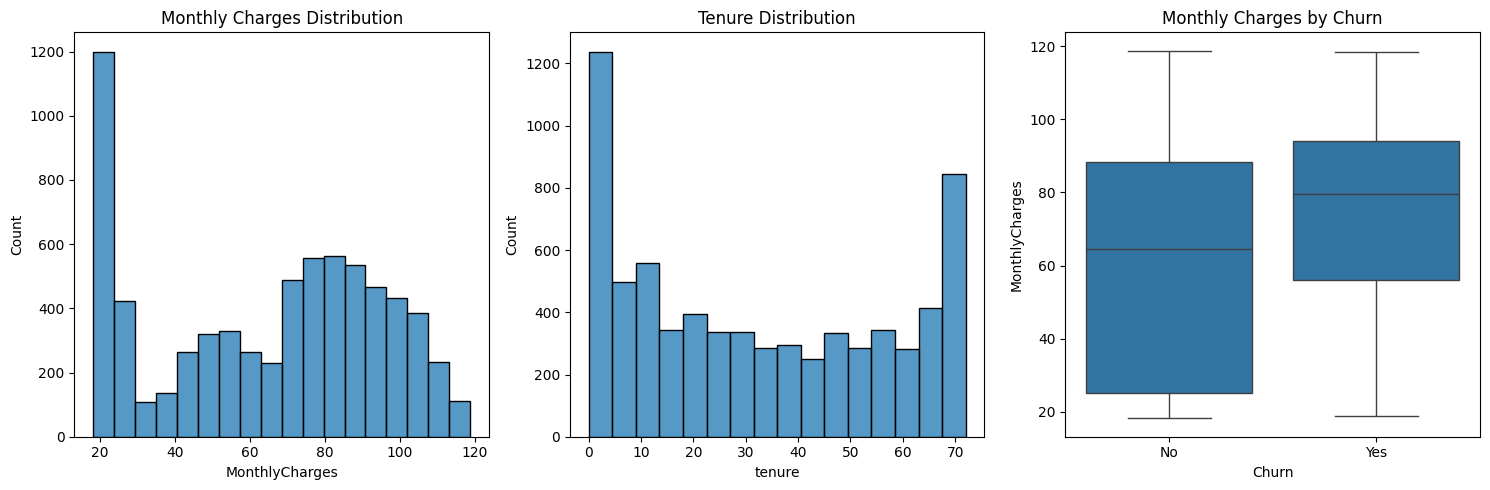

In [15]:
# Data exploration and assumption checking
def check_assumptions(df):
    # Check for missing values
    print("Missing values:\n", df.isnull().sum())

    # Convert TotalCharges to numeric
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # Basic statistics
    print("\nNumerical features summary:")
    print(df[['tenure', 'MonthlyCharges', 'TotalCharges']].describe())

    # Visualize distributions
    plt.figure(figsize=(15, 5))

    # Check normality assumption
    plt.subplot(1, 3, 1)
    sns.histplot(df['MonthlyCharges'])
    plt.title('Monthly Charges Distribution')

    plt.subplot(1, 3, 2)
    sns.histplot(df['tenure'])
    plt.title('Tenure Distribution')

    plt.subplot(1, 3, 3)
    sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
    plt.title('Monthly Charges by Churn')

    plt.tight_layout()
    plt.show()

# Run assumption checks
check_assumptions(df)

In [16]:
def preprocess_data(df):
    categorical_cols = ['gender', 'InternetService', 'Contract', 'PaymentMethod',
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
    df = pd.get_dummies(df, columns=categorical_cols)

    # Convert binary variables
    df['Churn'] = (df['Churn'] == 'Yes').astype(int)
    binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
    for col in binary_cols:
        df[col] = (df[col] == 'Yes').astype(int)

    # Handle TotalCharges
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna()

    return df

# Process and split data
df_processed = preprocess_data(df)
X = df_processed.drop(['Churn', 'customerID'], axis=1)
y = df_processed['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

# Linear Regression interpretation
lr_coef = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
})
print("Linear Regression Coefficients:")
print(lr_coef.sort_values('Coefficient', ascending=False).head())
print(f"R-squared: {lr_model.score(X_test_scaled, y_test):.4f}")
print(f"MSE: {mean_squared_error(y_test, lr_pred):.4f}")


Linear Regression Coefficients:
                           Feature  Coefficient
11     InternetService_Fiber optic     0.073268
37             StreamingMovies_Yes     0.031487
34                 StreamingTV_Yes     0.030760
13         Contract_Month-to-month     0.027578
18  PaymentMethod_Electronic check     0.022311
R-squared: 0.2522
MSE: 0.1459


In [22]:
# 2. Logistic Regression 
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)
log_pred = log_model.predict(X_test_scaled)

print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, log_pred):.4f}")
print("\nLogistic Regression Coefficients:")
print(pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_model.coef_[0]
}).sort_values('Coefficient', ascending=False).head())


Logistic Regression Results:
Accuracy: 0.7868

Logistic Regression Coefficients:
                        Feature  Coefficient
7                  TotalCharges     0.689447
11  InternetService_Fiber optic     0.367352
13      Contract_Month-to-month     0.310812
37          StreamingMovies_Yes     0.158654
34              StreamingTV_Yes     0.154262



GAM Accuracy: 0.7854


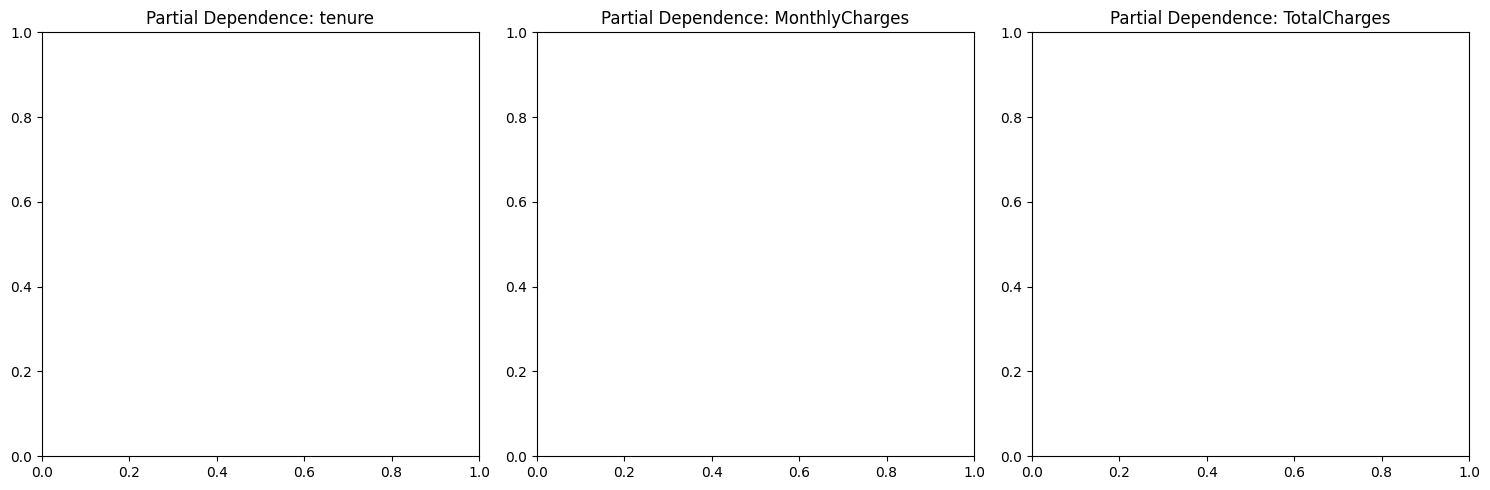

In [23]:
# GAM for non-linear relationships
# Using only numeric features: tenure, MonthlyCharges, TotalCharges
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_train_gam = pd.DataFrame(X_train_scaled, columns=X.columns)[numeric_features]
X_test_gam = pd.DataFrame(X_test_scaled, columns=X.columns)[numeric_features]

gam = LogisticGAM(s(0) + s(1) + s(2))
gam.fit(X_train_gam, y_train)
gam_pred = gam.predict(X_test_gam)

gam_accuracy = accuracy_score(y_test, gam_pred)
print(f"\nGAM Accuracy: {gam_accuracy:.4f}")

# Plot GAM partial dependence
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numeric_features):
    plt.subplot(1, 3, i+1)
    gam.partial_dependence(i, X=X_train_gam)
    plt.title(f'Partial Dependence: {feature}')
plt.tight_layout()
plt.show()